# Example: Arbor plus .swc morphology file

Example utilizing the **`LFPykit`** module for predictions of extracellular potentials using 
the line source approximation implementation `LineSourcePotential` with a passive neuron model set up in Arbor (https://arbor.readthedocs.io, https://github.com/arbor-sim/arbor). 

The neuron receives sinusoid synaptic current input in one arbitrary chosen control volume (CV). 
Its morphology is defined in the file `single_cell.swc`

In [1]:
%matplotlib inline

In [2]:
## arbor may be installed using pip:
#!pip install git+https://github.com/arbor-sim/arbor.git@595e4e3a436d6346d0a5edd13cd463d0b054d085

In [3]:
## if running on mybinder or similar, uncomment and run the following to install LFPykit. 
## Then restart the kernel.
#!pip install ..

In [4]:
# import modules
import numpy as np
import arbor
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
import pandas as pd

In [5]:
class Recipe (arbor.recipe):
    def __init__(self, cell):
        super().__init__()
     
        self.the_cell = cell

        self.vprobe_id = (0, 0)
        self.iprobe_id = (0, 1)
        self.cprobe_id = (0, 2)

        self.the_props = arbor.neuron_cable_properties()
        self.the_cat = arbor.default_catalogue()
        self.the_props.register(self.the_cat)
       
    def num_cells(self):
        return 1

    def num_sources(self, gid):
        return 0

    def cell_kind(self, gid):
        return arbor.cell_kind.cable

    def cell_description(self, gid):
        return self.the_cell

    def global_properties(self, kind):
        return self.the_props
    
    def probes(self, gid):
        return [
            arbor.cable_probe_membrane_voltage_cell(),
            arbor.cable_probe_total_current_cell(),
            arbor.cable_probe_stimulus_current_cell()
        ]
    
# define morphology (needed for arbor.place_pwlin)
morphology = arbor.load_swc_arbor('single_cell.swc')

# number of CVs per branch
nseg = 3

# Label dictionary
defs = {}
labels = arbor.label_dict(defs)

# decor
decor = arbor.decor()

# set initial voltage, temperature, axial resistivity, membrane capacitance
decor.set_property(
    Vm=-65,  # Initial membrane voltage [mV]
    tempK=300,  # Temperature [Kelvin]
    rL=10000,  # Axial resistivity [Ω cm]
    cm=0.01,  # Membrane capacitance [F/m**2]
)

# set passive mechanism all over
pas = arbor.mechanism('pas/e=-65')  # passive mech w. leak reversal potential (mV)
pas.set('g', 0.0001)  # leak conductivity (S/cm2)
decor.paint('(all)', pas)

# set sinusoid input current at mid point of terminating CV (segment)
iclamp = arbor.iclamp(5,  # stimulation onset (ms)
                      1E8,  # stimulation duration (ms)
                      -0.001,  # stimulation amplitude (nA)
                      frequency=0.1,  # stimulation frequency (kHz)
                      phase=0)  # stimulation phase)
try:
    # arbor >= 0.5.2 fix
    decor.place('(location 4 0.16667)', iclamp, '"iclamp"')
except TypeError:
    decor.place('(location 4 0.16667)', iclamp)

# number of CVs per branch
policy = arbor.cv_policy_fixed_per_branch(nseg)
decor.discretization(policy)

# create cell and set properties
cell = arbor.cable_cell(morphology, labels, decor)

# create single cell model
model = arbor.single_cell_model(cell)

# instantiate recipe with cell
recipe = Recipe(cell)

# instantiate simulation
context = arbor.context()
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)

# set up sampling on probes
schedule = arbor.regular_schedule(0.1)
v_handle = sim.sample(recipe.vprobe_id, schedule, arbor.sampling_policy.exact)
i_handle = sim.sample(recipe.iprobe_id, schedule, arbor.sampling_policy.exact)
c_handle = sim.sample(recipe.cprobe_id, schedule, arbor.sampling_policy.exact)

# run simulation for 500 ms of simulated activity and collect results.
sim.run(tfinal=500)

# extract time, V_m and I_m for each compartment
V_m_samples, V_m_meta = sim.samples(v_handle)[0]
I_m_samples, I_m_meta = sim.samples(i_handle)[0]
I_c_samples, I_c_meta = sim.samples(c_handle)[0]

In [6]:
# drop recorded V_m values and corresponding meta data of 
# zero-sized CVs (branch-point potentials)
inds = np.array([m.dist!=m.prox for m in V_m_meta])
V_m_samples = V_m_samples[:, np.r_[True, inds]]
V_m_meta = np.array(V_m_meta)[inds].tolist()

In [7]:
# note: the cables comprising the metadata for each probe
# should be the same, as well as the reported sample times.
assert V_m_meta==I_m_meta
assert (V_m_samples[:, 0]==I_m_samples[:, 0]).all()

# prep recorded data for plotting
time = V_m_samples[:, 0]
V_m = V_m_samples[:, 1:].T
I_m = I_m_samples[:, 1:].T
I_c = I_c_samples[:, 1:].T

In [8]:
# gather geometry of CVs and assign segments to each CV
p = arbor.place_pwlin(morphology)
x, y, z, d = [np.array([], dtype=float).reshape((0, 2))] * 4
CV_ind = np.array([], dtype=int)  # tracks which CV owns segment
for i, m in enumerate(I_m_meta):
    segs = p.segments([m])
    for j, seg in enumerate(segs):
        x = np.row_stack([x, [seg.prox.x, seg.dist.x]])
        y = np.row_stack([y, [seg.prox.y, seg.dist.y]])
        z = np.row_stack([z, [seg.prox.z, seg.dist.z]])
        d = np.row_stack([d, [seg.prox.radius * 2, seg.dist.radius * 2]])
        CV_ind = np.r_[CV_ind, i]

In [9]:
###############################################################################
# compute extracellular potential using segment information
###############################################################################
cell_geometry = lfpykit.CellGeometry(
    x=x,
    y=y,
    z=z,
    d=d
)

# membrane voltages, transmemrbane current and corresponding times
cell_geometry.V_m = V_m  # mV
cell_geometry.I_m = I_m + I_c  # nA, sum stimulation and transmembrane current to mimic sinusoid synapse
cell_geometry.time = time  # ms

# locations where extracellular potential is predicted 
dx = 1
dz = 1
axis = np.round([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
# axis = np.round(axis)
X, Y = np.meshgrid(np.linspace(axis[0], axis[1], int(np.diff(axis[:2]) // dx) + 1), 
                   np.linspace(axis[2], axis[3], int(np.diff(axis[2:]) // dz) + 1))
Z = np.zeros_like(X)

# LineSourcePotential object, get mapping for all segments per CV
lsp = lfpykit.LineSourcePotential(cell=cell_geometry, 
                                  x=X.flatten(), 
                                  y=Y.flatten(), 
                                  z=Z.flatten())
M_tmp = lsp.get_transformation_matrix()

# Define response matrix from M with columns weighted by area of each frusta
M = np.zeros((lsp.x.size, I_m.shape[0]))
for i in range(I_m.shape[0]):
    inds = CV_ind == i
    M[:, i] = M_tmp[:, inds] @ (cell_geometry.area[inds] / cell_geometry.area[inds].sum())

# Extracellular potential using segment information at last time step 
# in x,y-plane coordinates   
V_e = M @ cell_geometry.I_m[:, -1]

## Plotting
Plot the morphology and extracellular potential prediction

In [10]:
def create_polygon(x, y, d):
    """create a outline for each segment defined by 1D arrays `x`, `y`, `d`
    in x,y-plane which can be drawn using `plt.Polygon`
    
    Parameters
    ----------
    x: ndarray
    y: ndarray
    d: ndarray
    
    Returns
    -------
    x, y: nested list
    """
    # calculate angles
    dx = abs(np.diff(x))
    dy = np.diff(y)
    theta = np.arctan2(dy, dx)

    x = np.r_[x, x[::-1]]
    y = np.r_[y, y[::-1]]

    theta = np.r_[theta, theta[::-1]]
    d = np.r_[d, d[::-1]]

    # 1st corner:
    x[0] -= 0.5 * d[0] * np.sin(theta[0])
    y[0] += 0.5 * d[0] * np.cos(theta[0])

    # points between start and end of section, first side
    x[1:dx.size] -= 0.25 * d[1:dx.size] * (
        np.sin(theta[:dx.size - 1]) + np.sin(theta[1:dx.size]))
    y[1:dy.size] += 0.25 * d[1:dy.size] * (
        np.cos(theta[:dy.size - 1]) + np.cos(theta[1:dx.size]))

    # end of section, first side
    x[dx.size] -= 0.5 * d[dx.size] * np.sin(theta[dx.size])
    y[dy.size] += 0.5 * d[dy.size] * np.cos(theta[dy.size])

    # end of section, second side
    x[dx.size + 1] += 0.5 * d[dx.size + 1] * np.sin(theta[dx.size])
    y[dy.size + 1] -= 0.5 * d[dy.size + 1] * np.cos(theta[dy.size])

    # points between start and end of section, second side
    x[::-1][1:dx.size] += 0.25 * d[::-1][1:dx.size] * (
        np.sin(theta[::-1][:dx.size - 1]) + np.sin(theta[::-1][1:dx.size]))
    y[::-1][1:dy.size] -= 0.25 * d[::-1][1:dy.size] * (
        np.cos(theta[::-1][:dy.size - 1]) + np.cos(theta[::-1][1:dx.size]))

    # last corner:
    x[-1] += 0.5 * d[-1] * np.sin(theta[-1])
    y[-1] -= 0.5 * d[-1] * np.cos(theta[-1])
    
    return list(zip(x, y))

In [11]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw matplotlib colorbar without resizing the axes object
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

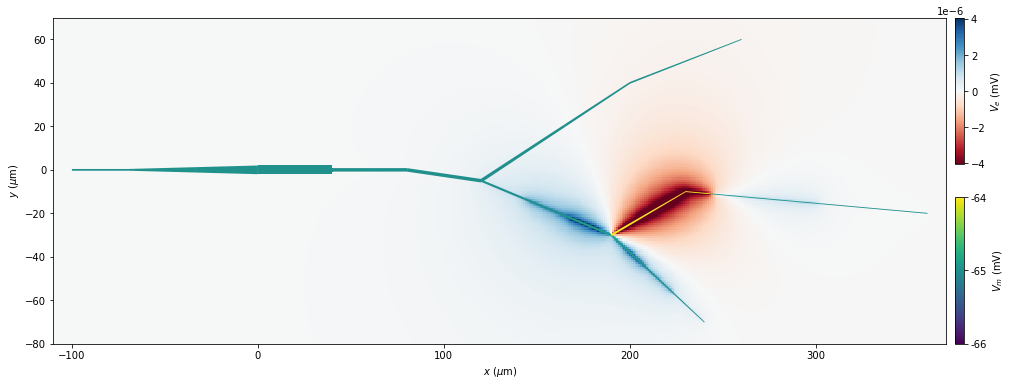

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# plot pcolormesh plot of V_e
im_V_e = ax.pcolormesh(X, Y, V_e.reshape(X.shape), 
                        shading='auto', cmap='RdBu', 
                        vmin=-abs(V_e).max() / 2, vmax=abs(V_e).max() / 2)
cb = colorbar(fig, ax, im_V_e, height=0.45, voffset=0.55)
cb.set_label('$V_e$ (mV)')

# add outline of each CV
norm = plt.Normalize(vmin=-66, vmax=-64)
colors = [plt.cm.viridis(norm(v)) for v in cell_geometry.V_m[:, -1]]
zips = []
for i in range(I_m.shape[0]):
    inds = CV_ind == i
    zips.append(create_polygon(x[inds, ].flatten(), y[inds, ].flatten(), d[inds, ].flatten()))
polycol = PolyCollection(zips,
                         edgecolors=colors,
                         facecolors=colors,
                         linewidths=0)    
im_V_m = ax.add_collection(polycol)

cb2 = colorbar(fig, ax, im_V_m, height=0.45)
cb2.set_ticks([0, 0.5, 1])
cb2.set_ticklabels([-66, -65, -64])
cb2.set_label(r'$V_m$ (mV)')

# outline of segments making up each CV:
if False:
    zips = []
    for x_, y_, d_ in zip(x, y, d):
        zips.append(create_polygon(x_, y_, d_))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='none',
                             linewidths=0.5)
    ax.add_collection(polycol)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_xlabel(r'$x$ ($\mu$m)')
ax.set_ylabel(r'$y$ ($\mu$m)')

fig.savefig('Example_Arbor_swc.png', dpi=300, bbox_inches='tight')

## Notes on output:
The spatial discretization is here deliberately coarse with only 3 CVs per branch. 
Hence the branch receiving input about 1/6 of the way from its root 
(from `decor.place('(location 4 0.16667)', iclamp)`) is treated
as 3 separate line sources with homogeneous current density per length unit each, even if 
the diameter and direction varies with position due to the fact 
that each CV may  be composed of multiple segments. 

The parameter `nseg = 3` above can be changed above to affect the number of CVs per branch. 